# DIRECTi tutorial

In [1]:
import Cell_BLAST as cb
cb.config.RANDOM_SEED = 0  # Ensure repeatability

## Unsupervised dimension reduction

Let's first load a dataset (*Baron, M. et al. Cell Syst, 2016*), which profiles >8,000 human pancreatic islet cells.

Here we normalized the dataset so that the resulting model, once fitted, can be used to project other datasets normalized in the same way.

> Theoretically speaking, read count distribution may deviate from negative binomial due to the scaling, but practically it still fits very well.

In [2]:
baron_human = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Baron_human/data.h5").normalize()

Now we build and fit a DIRECTi model with the one-step `fit_DIRECTi` function.

We set latent space dimensionality to 10, and go with 20 intrinsic clusters.

To save time, we only train for 50 epochs. The model has not fully converged but already works well.

In [3]:
model = cb.directi.fit_DIRECTi(
    baron_human, baron_human.uns["seurat_genes"],
    latent_dim=10, cat_dim=20, epoch=50,
    path="./baron_human_model"
)

[DIRECTi epoch 0] train=2.451, val=2.426, time elapsed=1.5s Best save...
[DIRECTi epoch 1] train=2.412, val=2.356, time elapsed=0.7s Best save...
[DIRECTi epoch 2] train=1.585, val=0.864, time elapsed=0.7s Best save...
[DIRECTi epoch 3] train=0.778, val=0.818, time elapsed=0.7s Best save...
[DIRECTi epoch 4] train=0.746, val=0.814, time elapsed=0.7s Best save...
[DIRECTi epoch 5] train=0.742, val=0.754, time elapsed=0.7s Best save...
[DIRECTi epoch 6] train=0.738, val=0.741, time elapsed=0.7s Best save...
[DIRECTi epoch 7] train=0.734, val=0.738, time elapsed=0.7s Best save...
[DIRECTi epoch 8] train=0.731, val=0.731, time elapsed=0.7s Best save...
[DIRECTi epoch 9] train=0.725, val=0.733, time elapsed=0.8s
[DIRECTi epoch 10] train=0.714, val=0.709, time elapsed=0.8s Best save...
[DIRECTi epoch 11] train=0.701, val=0.703, time elapsed=0.7s Best save...
[DIRECTi epoch 12] train=0.693, val=0.694, time elapsed=0.7s Best save...
[DIRECTi epoch 13] train=0.687, val=0.685, time elapsed=0.7s 

We can project cells into the low dimensional latent space using the `inference` method.
It is recommended that you store the returned latent space into the `latent` slot of the original dataset object, which facilitates visualization.

In [4]:
baron_human.latent = model.inference(baron_human)

In [5]:
ax = baron_human.visualize_latent("cell_ontology_class")

[  Info   ] Computing tSNE...


We see that different cell types can readily be distinguished.

Note that though 20-dimensional categorical latent was used, far less clusters form in the latent space. This is because the model is flexible to discard categories or to use multiple categories to represent the same cluster if a redundant number of categories is specified.

You can also save the model for future use. It is straightforward to load a saved model.

In [6]:
model.save()
model.close()
del model
model = cb.directi.DIRECTi.load("./baron_human_model")

[  Info   ] Loading latent module weights...
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckpt
INFO:tensorflow:Restoring parameters from ./baron_human_model/weights/latent/save.ckp

We can also project other datasets with the same model. Here we test with the Muraro dataset (*Muraro, M. et al. Cell Systems, 2016*)

There will be a warning saying that we have some genes missing in the new dataset, but it doesn't really matter. Distinct cell types are still well separated.

[ Warning ] 18 out of 769 variables are not found, will be set to zero!
[  Info   ] Computing tSNE...


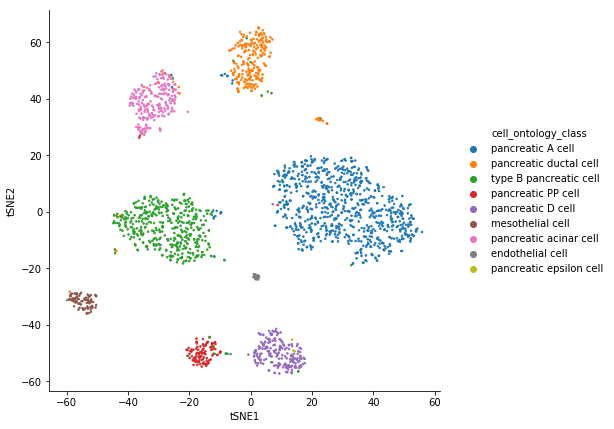

In [7]:
muraro = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Muraro/data.h5").normalize()
muraro.latent = model.inference(muraro)
ax = muraro.visualize_latent("cell_ontology_class")

## Systematical bias / batch effect removal

If we train on a "meta" dataset merged from multiple datasets, we'll find significant systematical bias among them.

In [8]:
combined_dataset = cb.data.ExprDataSet.merge_datasets({
    "Baron_human": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Baron_human/data.h5"),
    "Segerstolpe": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Segerstolpe/data.h5"),
    "Muraro": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Muraro/data.h5"),
    "Xin": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Xin_2016/data.h5"),
    "Lawlor": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Lawlor/data.h5")
}, meta_col="study", merge_uns_slots=["seurat_genes"]).normalize()

[ Warning ] 16507 out of 36632 variables are not found, will be set to zero!
[ Warning ] 15007 out of 36632 variables are not found, will be set to zero!
[ Warning ] 17586 out of 36632 variables are not found, will be set to zero!
[ Warning ] 5035 out of 36632 variables are not found, will be set to zero!
[ Warning ] 16747 out of 36632 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...


In [9]:
model = cb.directi.fit_DIRECTi(
    combined_dataset, combined_dataset.uns["seurat_genes"],
    latent_dim=10, cat_dim=20, epoch=20,
    path="/tmp/cb/examples/pancreas_unaligned_model"
)
combined_dataset.latent = model.inference(combined_dataset)

[DIRECTi epoch 0] train=1.717, val=1.715, time elapsed=2.1s Best save...
[DIRECTi epoch 1] train=1.502, val=0.959, time elapsed=1.4s Best save...
[DIRECTi epoch 2] train=0.752, val=0.789, time elapsed=1.4s Best save...
[DIRECTi epoch 3] train=0.697, val=0.709, time elapsed=1.4s Best save...
[DIRECTi epoch 4] train=0.691, val=0.695, time elapsed=1.4s Best save...
[DIRECTi epoch 5] train=0.686, val=0.691, time elapsed=1.4s Best save...
[DIRECTi epoch 6] train=0.679, val=0.681, time elapsed=1.4s Best save...
[DIRECTi epoch 7] train=0.666, val=0.677, time elapsed=1.4s Best save...
[DIRECTi epoch 8] train=0.650, val=0.671, time elapsed=1.4s Best save...
[DIRECTi epoch 9] train=0.640, val=0.655, time elapsed=1.5s Best save...
[DIRECTi epoch 10] train=0.633, val=0.639, time elapsed=1.4s Best save...
[DIRECTi epoch 11] train=0.628, val=0.633, time elapsed=1.4s Best save...
[DIRECTi epoch 12] train=0.625, val=0.630, time elapsed=1.4s Best save...
[DIRECTi epoch 13] train=0.621, val=0.624, time 

[  Info   ] Computing tSNE...


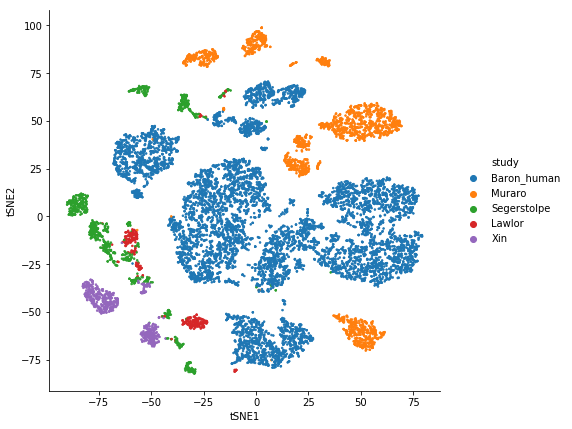

In [10]:
ax = combined_dataset.visualize_latent("study")

You can remove the systematical bias from the latent space simply by specifying a `batch_effect` column, which is "study" in this case.

This time we train the model for 100 epoches to get better convergence.

In [11]:
model_rmbatch = cb.directi.fit_DIRECTi(
    combined_dataset, combined_dataset.uns["seurat_genes"], batch_effect="study", 
    latent_dim=10, cat_dim=20, epoch=100,
    path="/tmp/cb/examples/pancreas_aligned_model"
)
combined_dataset.latent = model_rmbatch.inference(combined_dataset)

[DIRECTi epoch 0] train=1.716, val=1.714, time elapsed=2.4s Regular save...
[DIRECTi epoch 1] train=1.478, val=0.988, time elapsed=1.6s
[DIRECTi epoch 2] train=0.755, val=0.789, time elapsed=1.6s
[DIRECTi epoch 3] train=0.693, val=0.708, time elapsed=1.6s
[DIRECTi epoch 4] train=0.681, val=0.680, time elapsed=1.6s
[DIRECTi epoch 5] train=0.665, val=0.664, time elapsed=1.7s
[DIRECTi epoch 6] train=0.647, val=0.660, time elapsed=1.6s
[DIRECTi epoch 7] train=0.635, val=0.652, time elapsed=1.6s
[DIRECTi epoch 8] train=0.628, val=0.636, time elapsed=1.6s
[DIRECTi epoch 9] train=0.624, val=0.632, time elapsed=1.6s
[DIRECTi epoch 10] train=0.621, val=0.630, time elapsed=1.6s Regular save...
[DIRECTi epoch 11] train=0.616, val=0.621, time elapsed=1.7s
[DIRECTi epoch 12] train=0.609, val=0.612, time elapsed=1.6s
[DIRECTi epoch 13] train=0.602, val=0.607, time elapsed=1.6s
[DIRECTi epoch 14] train=0.598, val=0.600, time elapsed=1.6s
[DIRECTi epoch 15] train=0.595, val=0.598, time elapsed=1.6s
[D

We see that systematical bias is largely removed. Cells of the same cell type from different studies are well aligned.

[  Info   ] Computing tSNE...


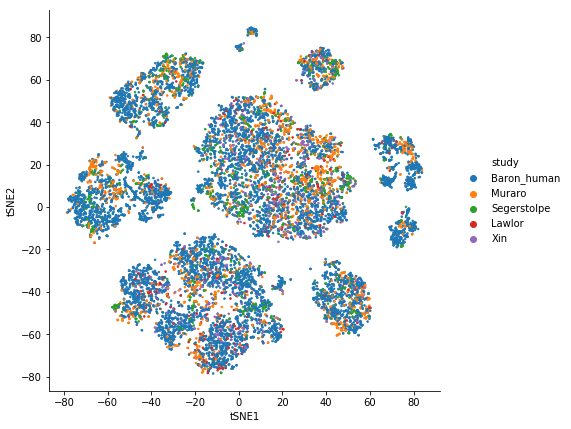

In [12]:
ax = combined_dataset.visualize_latent("study")

[  Info   ] Using cached tSNE...


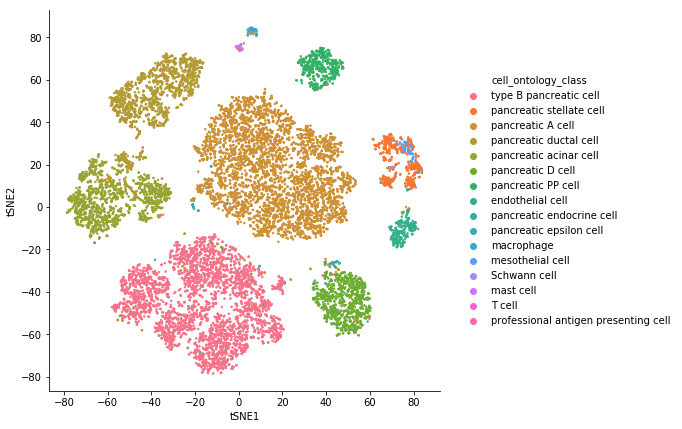

In [13]:
ax = combined_dataset.visualize_latent("cell_ontology_class")